Y_data: 20640
y_data: 19648
y_data: 18665
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Predicción de precios de casas sin ruido:
MSE: 0.17187019354434674
MAE: 0.28053887907819397
RMSE: 0.41457230195027106
R2: 0.8191442624986691


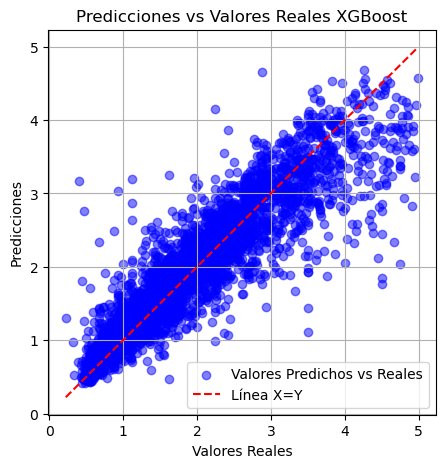


Epsilon = 1e-07
Error del ruido:
MSE: 2801636487298545.5
MAE: 13262357.771475486
RMSE: 52930487.31400973
R2: -1163243326766233.2

Predicción de precios con ruido:
MSE: 0.18783849005323133
MAE: 0.2954551467990671
RMSE: 0.4334033802974215
R2: 0.8023411276316039

Epsilon = 0.0001
Error del ruido:
MSE: 2770597944.676884
MAE: 13228.620088574376
RMSE: 52636.46972087779
R2: -1150356080.1364448

Predicción de precios con ruido:
MSE: 0.18862406864105874
MAE: 0.2967528726180246
RMSE: 0.43430872503446066
R2: 0.8015144782170845

Epsilon = 0.1
Error del ruido:
MSE: 2813.9477344119086
MAE: 13.271307016751697
RMSE: 53.0466562038731
R2: -1167.3549735175936

Predicción de precios con ruido:
MSE: 0.18918966031962356
MAE: 0.2985094911397509
RMSE: 0.4349593777809872
R2: 0.8009193168453423

Epsilon = 0.5
Error del ruido:
MSE: 113.88909271088073
MAE: 2.690978927417077
RMSE: 10.671883278544641
R2: -46.28690809389637

Predicción de precios con ruido:
MSE: 0.18854368152043696
MAE: 0.2934406486414662
RMSE: 0.4

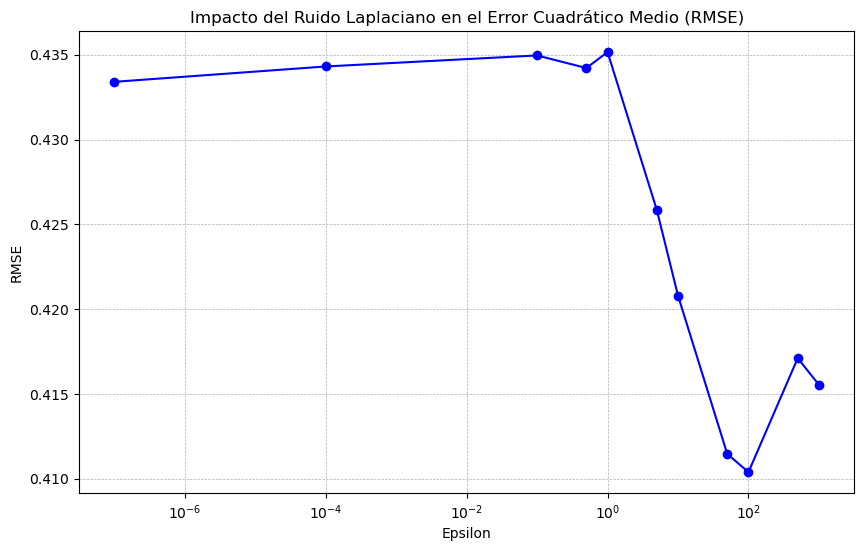

In [23]:
import numpy as np
import ModeloBase
from ModeloBase import read_data_model, add_laplace_noise, rmse
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

np.random.seed(42) 

all_data = fetch_california_housing()
X_train_val, X_val, X_test, Y_train_val, Y_val, Y_test = read_data_model(all_data, 'MedInc')

# Entrenamos el scanner con los datos train_val para evitar fuga de datos antes del entrenamiento
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

xgbr = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir los parámetros para la búsqueda en cuadrícula
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train_val_scaled, Y_train_val)
best_params = grid_search.best_params_

# Imprimir los mejores parámetros encontrados
print("Best parameters found:", best_params)

# Initial model training without noise
model_original = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
model_original.fit(X_train_val_scaled, Y_train_val)
Y_predict = model_original.predict(X_test_scaled)

# Evaluate original model (without noise)
MSE_original = mse(Y_test, Y_predict)
MAE_original = mae(Y_test, Y_predict)
RMSE_original = rmse(Y_test, Y_predict)
R2_original = r2(Y_test, Y_predict)

print("Predicción de precios de casas sin ruido:")
print(f"MSE: {MSE_original}")
print(f"MAE: {MAE_original}")
print(f"RMSE: {RMSE_original}")
print(f"R2: {R2_original}")

# Diagrama de dispersión de valores predichos vs valores reales
plt.figure(figsize=(5, 5))
plt.scatter(Y_test, Y_predict, alpha=0.5, color='blue', label='Valores Predichos vs Reales')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Línea X=Y')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales XGBoost')
plt.legend()
plt.grid(True)

# Guardar la imagen
plt.savefig('diagrama_dispersion_XGboost.png',  dpi=300)
plt.show()

# Iterate over different epsilon values
epsilon_values = [0.0000001, 0.0001, 0.1, 0.5, 1.0, 5 , 10, 50, 100, 500, 1000]
results = []

for epsilon in epsilon_values:
    print(f"\nEpsilon = {epsilon}")

    # Step 1: Add Laplacian noise to the income column in the training set only
    X_train_val_noisy = add_laplace_noise(X_train_val, epsilon)

    MSE_original = mse(X_train_val, X_train_val_noisy)
    MAE_original = mae(X_train_val, X_train_val_noisy)
    RMSE_original = rmse(X_train_val, X_train_val_noisy)
    R2_original = r2(X_train_val, X_train_val_noisy)

    print("Error del ruido:")
    print(f"MSE: {MSE_original}")
    print(f"MAE: {MAE_original}")
    print(f"RMSE: {RMSE_original}")
    print(f"R2: {R2_original}")

    # Step 2: Train the model using noisy income values for training
    scaler = StandardScaler()
    X_train_val_noisy_scaled = scaler.fit_transform(X_train_val_noisy)
    X_test_scaled = scaler.transform(X_test)
    
    model_noisy = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    model_noisy.fit(X_train_val_noisy_scaled, Y_train_val)
    Y_predict = model_noisy.predict(X_test_scaled)

    # Step 3: Evaluate the model trained with noisy data using the original validation set
    MSE_noisy = mse(Y_test, Y_predict)
    MAE_noisy = mae(Y_test, Y_predict)
    RMSE_noisy = rmse(Y_test, Y_predict)
    R2_noisy = r2(Y_test, Y_predict)

    print("\nPredicción de precios con ruido:")
    print(f"MSE: {MSE_noisy}")
    print(f"MAE: {MAE_noisy}")
    print(f"RMSE: {RMSE_noisy}")
    print(f"R2: {R2_noisy}")

    results.append((epsilon, MSE_noisy, MAE_noisy, RMSE_noisy, R2_noisy))

# Display the results
import pandas as pd
results_df = pd.DataFrame(results, columns=["Epsilon", "MSE","MAE", "RMSE", "R2"])
print(results_df)

# Graficar el RMSE en función del valor de epsilon
plt.figure(figsize=(10, 6))
plt.plot(results_df["Epsilon"], results_df["RMSE"], marker='o', linestyle='-', color='blue')
plt.xscale('log')  # Usar escala logarítmica para epsilon
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('Impacto del Ruido Laplaciano en el Error Cuadrático Medio (RMSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('XGBoost_rmse_vs_epsilon.png', dpi=300)
plt.show()
